In [9]:
# Voxel-based Ray Tracing
# No refraction for simplicity!
# Single point light source for simplicity!
# FB36 - 20130829

# See: http://code.activestate.com/recipes/578652-voxel-based-ray-tracing/

import math
from PIL import Image
from matplotlib import pyplot as plt

In [3]:
imgx = 400; imgy = 400 ; imgz = 400 # voxel-box size
image = Image.new("RGB", (imgx, imgy))
pixels = image.load()

# each voxel can have RGB color
voxelRGB = [[[(0, 0, 0) for x in range(imgx)] for y in range(imgy)] for z in range(imgz)]

# each voxel can have an opacity coefficient 0 or 1 (for simplicity)
opacity = [[[0 for x in range(imgx)] for y in range(imgy)] for z in range(imgz)]

# each voxel can have a 3d normal unit vector (for reflections/refractions)
normal = [[[(0.0, 0.0, 0.0) for x in range(imgx)] for y in range(imgy)] for z in range(imgz)]

# each voxel can have a reflectivity coefficient between 0 and 1
reflectivity = [[[0.0 for x in range(imgx)] for y in range(imgy)] for z in range(imgz)]

eye = (imgx / 2.0, 250.0, -100.0)
light = (- 10.0, -10.0, -10.0)
ambientBrightness = 0.3 # between 0 and 1

In [10]:
# cx, cy, cz: center; r: radius (in voxels)
# rc: reflectivity coefficient between 0 and 1
def CreateMirrorSphere(cx, cy, cz, r, colorRGB, rc):
    print("Creating mirror sphere...")
    # sphere is set of voxels which have distance = r to center
    for z in range(imgz):
        for y in range(imgy):
            for x in range(imgx):
                dx = x - cx
                dy = y - cy
                dz = z - cz
                d = math.sqrt(dx * dx + dy * dy + dz * dz)
                if abs(d - r) < 1.0:
                    voxelRGB[z][y][x] = colorRGB
                    opacity[z][y][x] = 1
                    normal[z][y][x] = (dx / d, dy / d, dz / d)
                    reflectivity[z][y][x] = rc
    
def CreateCheckerboardFloor(sqrX, sqrZ, colorRGB0, colorRGB1):
    print("Creating checkerboard floor...")
    for z in range(imgz):
        for x in range(imgx):
            if int(x / sqrX) % 2 != int(z / sqrZ) % 2: # xor
                voxelRGB[z][imgy - 1][x] = colorRGB0
            else:
                voxelRGB[z][imgy - 1][x] = colorRGB1
            opacity[z][imgy - 1][x] = 1
            normal[z][imgy - 1][x] = (0.0, -1.0, 0.0)

def CombineColors(c0, c1, w):
    return (int(round(c0[0] + (c1[0] - c0[0]) * w)),
            int(round(c0[1] + (c1[1] - c0[1]) * w)),
            int(round(c0[2] + (c1[2] - c0[2]) * w)))
    
# 3D Reflection (all vectors are unit vectors)
def Reflection(normalVector, incidentRayVector):
    (nx, ny, nz) = normalVector
    (ix, iy, iz) = incidentRayVector
    dotProduct = nx * ix + ny * iy + nz * iz
    rx = ix - 2 * dotProduct * nx
    ry = iy - 2 * dotProduct * ny
    rz = iz - 2 * dotProduct * nz    
    return (rx, ry, rz)

def LightIntensity(surfaceVoxelCoordinates, surfaceNormalVector):
    (svx, svy, svz) = surfaceVoxelCoordinates
    (nx, ny, nz) = surfaceNormalVector
    (Lx, Ly, Lz) = light
    dx = Lx - svx
    dy = Ly - svy
    dz = Lz - svz
    d = math.sqrt(dx * dx + dy * dy + dz * dz)
    dx = dx / d; dy = dy / d; dz = dz / d # unit vector towards light
    cosT = nx * dx + ny * dy + nz * dz
    if cosT < 0.0: cosT = 0.0 # the surface faces away from the light source
    return cosT

def ShadowIntensity(rayX, rayY, rayZ):
    (Lx, Ly, Lz) = light
    dx = Lx - rayX
    dy = Ly - rayY
    dz = Lz - rayZ
    d = math.sqrt(dx * dx + dy * dy + dz * dz)
    dx = dx / d; dy = dy / d; dz = dz / d # unit vector towards light

    while True: # shadow ray tracing

        rayX += dx; rayY += dy; rayZ += dz # move the ray by 1 voxel

        rayXint = int(round(rayX))
        rayYint = int(round(rayY))
        rayZint = int(round(rayZ))

        # if ray goes outside of the voxel-box
        if rayXint < 0 or rayXint > imgx - 1 \
            or rayYint < 0 or rayYint > imgy - 1 \
            or rayZint < 0 or rayZint > imgz - 1:
            return 1.0

        # if ray hits an object
        if opacity[rayZint][rayYint][rayXint] == 1:
            # stop tracing here for simplicity
            return 0.0

        # if ray hits the light source
        vx = Lx - rayX
        vy = Ly - rayY
        vz = Lz - rayZ
        d = math.sqrt(vx * vx + vy * vy + vz * vz)
        if d < 1.0:
            return 1.0

# Ray Tracer (traces the ray and returns an RGB color)
def RayTrace(rayX, rayY, rayZ, dx, dy, dz):

    brightness = 1.0 # the ray has full brightness at the beginning
    color = (0, 0, 0)

    while True:

        rayX += dx; rayY += dy; rayZ += dz # move the ray by 1 voxel

        rayXint = int(round(rayX))
        rayYint = int(round(rayY))
        rayZint = int(round(rayZ))

        # if ray goes outside of the voxel-box
        if rayXint < 0 or rayXint > imgx - 1 \
            or rayYint < 0 or rayYint > imgy - 1 \
            or rayZint < 0 or rayZint > imgz - 1:
            return color

        # if ray hits an object
        if opacity[rayZint][rayYint][rayXint] == 1:

            # if ray hits a non-reflective object
            if reflectivity[rayZint][rayYint][rayXint] == 0.0:
                brightness *= ShadowIntensity(rayX, rayY, rayZ)
                brightness *= LightIntensity((rayX, rayY, rayZ), \
                                             normal[rayZint][rayYint][rayXint])
                brightness = brightness * (1.0 - ambientBrightness) + ambientBrightness
                color = CombineColors(color, voxelRGB[rayZint][rayYint][rayXint], brightness)                
                return color

            # if ray hits a reflective object
            if reflectivity[rayZint][rayYint][rayXint] > 0.0:
                brightness *= reflectivity[rayZint][rayYint][rayXint]

                brightnessTemp = ShadowIntensity(rayX, rayY, rayZ)
                brightnessTemp *= LightIntensity((rayX, rayY, rayZ), \
                                                 normal[rayZint][rayYint][rayXint])
                brightnessTemp = brightnessTemp * (1.0 - ambientBrightness) + ambientBrightness
                colorTemp = voxelRGB[rayZint][rayYint][rayXint]
                colorTemp = (int(colorTemp[0] * brightnessTemp), \
                             int(colorTemp[1] * brightnessTemp), \
                             int(colorTemp[2] * brightnessTemp))

                color = CombineColors(color, colorTemp, \
                                      1.0 - reflectivity[rayZint][rayYint][rayXint])
                (dx, dy, dz) = Reflection(normal[rayZint][rayYint][rayXint], (dx, dy, dz))

In [11]:
def CreateScene():
    print("Creating scene...")
    CreateCheckerboardFloor(20, 20, (255, 255, 0), (0, 0, 255))
    CreateMirrorSphere(imgx / 2.0, imgy / 2.0, imgz / 2, 150.0, (0, 255, 0), 0.8)

CreateScene()

Creating scene...
Creating checkerboard floor...
Creating mirror sphere...


In [12]:
def RenderScene():
    print("Rendering scene...")
    for ky in range(imgy):
        print(str(100 * ky / (imgy - 1)).zfill(3) + "%")
        for kx in range(imgx):
            dx = kx - eye[0]
            dy = ky - eye[1]
            dz = 0.0 - eye[2]
            d = math.sqrt(dx * dx + dy * dy + dz * dz)
            dx = dx / d; dy = dy / d; dz = dz / d # ray unit vector
            pixels[kx, ky] = RayTrace(kx, ky, 0, dx, dy, dz)

RenderScene()

Rendering scene...
0.0%
0.2506265664160401%
0.5012531328320802%
0.7518796992481203%
1.0025062656641603%
1.2531328320802004%
1.5037593984962405%
1.7543859649122806%
2.0050125313283207%
2.255639097744361%
2.506265664160401%
2.756892230576441%
3.007518796992481%
3.2581453634085213%
3.508771929824561%
3.7593984962406015%
4.010025062656641%
4.260651629072682%
4.511278195488722%
4.761904761904762%
5.012531328320802%
5.2631578947368425%
5.513784461152882%
5.764411027568922%
6.015037593984962%
6.265664160401003%
6.516290726817043%
6.7669172932330826%
7.017543859649122%
7.268170426065163%
7.518796992481203%
7.769423558897243%
8.020050125313283%
8.270676691729323%
8.521303258145364%
8.771929824561404%
9.022556390977444%
9.273182957393484%
9.523809523809524%
9.774436090225564%
10.025062656641603%
10.275689223057643%
10.526315789473685%
10.776942355889725%
11.027568922305765%
11.278195488721805%
11.528822055137844%
11.779448621553884%
12.030075187969924%
12.280701754385966%
12.531328320802006%
12.

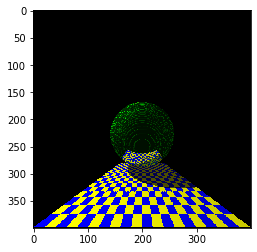

In [13]:
plt.imshow(image)
plt.show()